# Setup

Clone GitHub [repository](https://github.com/ultralytics/yolov5), install [dependencies](https://github.com/ultralytics/yolov5/blob/master/requirements.txt) and check PyTorch and GPU.

In [1]:
#!git clone https://github.com/ultralytics/yolov5  # clone
#%cd yolov5
#%pip install -qr requirements.txt comet_ml  # install

#import torch
#import utils
#display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-294-gdb125a20 Python-3.9.18 torch-2.2.1 CPU


Setup complete ✅ (8 CPUs, 8.0 GB RAM, 202.9/233.5 GB disk)


# Detect

In [189]:
!python detect.py --weights runs/train/exp5/weights/best.pt --img 640 --conf 0.33 --source data/images
# display.Image(filename='runs/detect/exp/zidane.jpg', width=600)

detect: weights=['runs/train/exp5/weights/best.pt'], source=data/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.33, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-294-gdb125a20 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/5 /content/yolov5/data/images/bus.jpg: 640x480 2 masks, 52.2ms
image 2/5 /content/yolov5/data/images/detect.jpeg: 480x640 3 masks, 47.9ms
image 3/5 /content/yolov5/data/images/detect2.jpeg: 448x640 1 mask, 50.4ms
image 4/5 /content/yolov5/data/images/picasso.jpg: 640x640 (no detections), 11.6ms
image 5/5 /content/yolov5/data/i

# Train

[Roboflow](https://roboflow.com/?ref=ultralytics) enables you to easily **organize, label, and prepare** a high quality dataset with your own custom data. Roboflow also makes it easy to establish an active learning pipeline, collaborate with your team on dataset improvement, and integrate directly into your model building workflow with the `roboflow` pip package.

In [ ]:
#@title Select YOLOv5 🚀 logger {run: 'auto'}
logger = 'Comet' #@param ['Comet', 'ClearML', 'TensorBoard']

if logger == 'Comet':
  %pip install -q comet_ml
  import comet_ml; comet_ml.init()
elif logger == 'ClearML':
  %pip install -q clearml
  import clearml; clearml.browser_login()
elif logger == 'TensorBoard':
  %load_ext tensorboard
  %tensorboard --logdir runs/train

In [ ]:
#import os
#os.getcwd()
#os.chdir('/content/yolov5')
# Required to run in colab

In [ ]:
!python train.py --img 640 --batch 30 --epochs 30 --data maskdata-2/data.yaml --weights yolov5s.pt --cache --hyp data/hyps/hyp.scratch-high.yaml

2024-03-14 11:17:32.132112: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-14 11:17:32.132167: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-14 11:17:32.134243: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=, data=maskdata-2/data.yaml, hyp=data/hyps/hyp.scratch-high.yaml, epochs=30, batch_size=30, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=F

# Extract boarder

In [195]:
import torch
from models.common import DetectMultiBackend
from utils.dataloaders import LoadImages
from utils.general import non_max_suppression, scale_boxes
from utils.augmentations import letterbox

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# The function to extract bounding boxes (provided earlier)
def extract_bboxes_from_yolov5_output(output, img_width, img_height, conf_thres=0.38):
    """
    Extracts the bounding box from the output of YOLOv5.

    :param output: The output tensor of the YOLOv5 model.
    :param img_width: width of the original image.
    :param img_height: Height of the original image.
    :param conf_thres: Confidence threshold, used for filtering low confidence detections.
    :return: list of bounding boxes, each in [x_min, y_min, x_max, y_max] format.
    """
    bboxes = []
    for detection in output:
        # Get the confidence score and the class ID
        confidence, class_id = detection[4], detection[5]

        # Apply the confidence threshold
        if confidence >= conf_thres:
            # Extract the bounding box coordinates
            x_center, y_center, width, height = detection[0:4]
            x_min = int((x_center - width / 2) * img_width)
            y_min = int((y_center - height / 2) * img_height)
            x_max = int((x_center + width / 2) * img_width)
            y_max = int((y_center + height / 2) * img_height)

            bboxes.append([x_min, y_min, x_max, y_max])

    return bboxes



# Load your custom model
model = DetectMultiBackend('runs/train/exp5/weights/best.pt', device=device)
stride, names, pt, jit, onnx = model.stride, model.names, model.pt, model.jit, model.onnx
imgsz = [640, 640]  # Size that YOLOv5 model expects
half = device.type != 'cpu'  # Half precision only supported on CUDA

if pt and half:
    model.model.half()  # to FP16

# Load the image
dataset = LoadImages('data/images/detect.jpeg', img_size=imgsz)
for path, img, im0, _, s in dataset:
    # Your processing code here

    img = torch.from_numpy(img).to(device)
    img = img.half() if half else img.float()  # uint8 to fp16/32
    img /= 255  # 0 - 255 to 0.0 - 1.0
    if len(img.shape) == 3:
        img = img[None]  # expand for batch dim

    # Inference
    pred = model(img, augment=False, visualize=False)

    # Apply non-max suppression to predictions
    pred = non_max_suppression(pred, 0.25, 0.45, None, False, max_det=1000)

    # Process detections
    for i, det in enumerate(pred):  # detections per image
        if len(det):
            # Rescale boxes from img_size to im0 size
            det[:, :4] = scale_boxes(img.shape[2:], det[:, :4], im0.shape).round()

            # Extract bounding boxes (modify this function based on your actual output format)
            bboxes = extract_bboxes_from_yolov5_output(det, im0.shape[1], im0.shape[0])
            print(bboxes)  # Now you have the bounding boxes



Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients


[[78897, 9776, 385815, 194298], [294780, 45214, 990114, 235846], [49419, 16802, 250563, 171385]]


In [203]:
scaled_bboxes = [[180, 150, 248, 300], [280, 168, 372, 323], [774, 237, 844, 329]]

# Style Transfer

In [140]:
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [155]:


loader = transforms.Compose([
    transforms.Resize((640,908)),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img = image_loader("./data/images/picasso.jpg")
content_img= image_loader("./data/images/detect.jpeg")



print(style_img.size())
print(content_img.size())


torch.Size([1, 3, 640, 908])
torch.Size([1, 3, 640, 908])


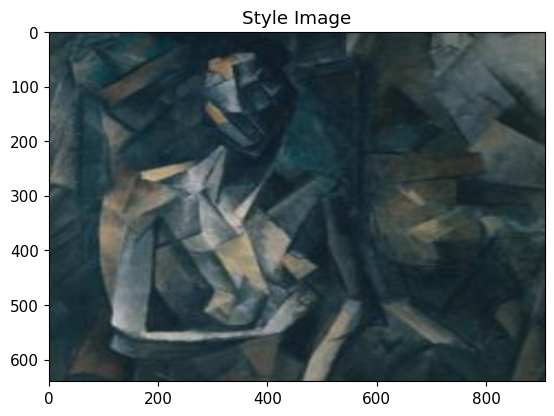

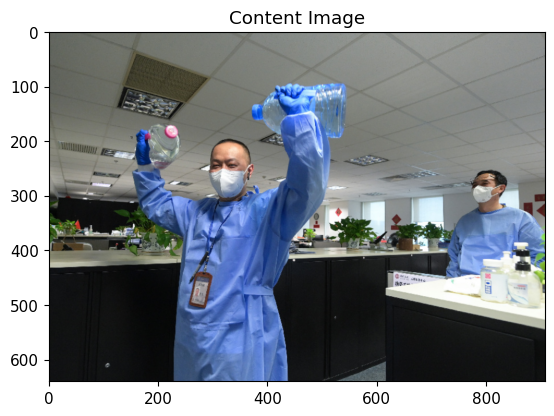

In [156]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.show()  # Explicitly show the plot in Colab

plt.figure()
imshow(style_img, title='Style Image') 
imshow(content_img, title='Content Image')

In [157]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [158]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

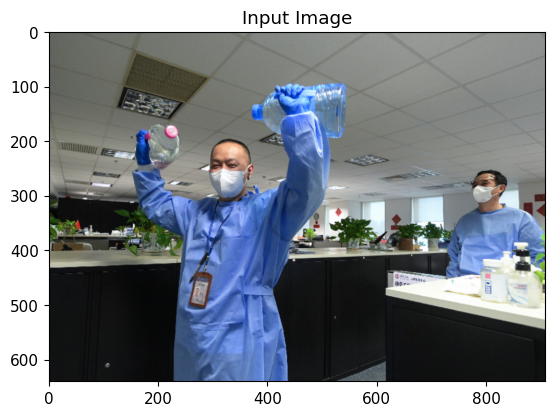

In [159]:
input_img = content_img.clone()
# if you want to use white noise by using the following code:
#
# .. code-block:: python
#
#    input_img = torch.randn(content_img.data.size())

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [160]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 0.335814 Content Loss: 5.433315

run [100]:
Style Loss : 0.334402 Content Loss: 5.429282

run [150]:
Style Loss : 0.333333 Content Loss: 5.424826

run [200]:
Style Loss : 0.332404 Content Loss: 5.420191

run [250]:
Style Loss : 0.331621 Content Loss: 5.415580

run [300]:
Style Loss : 0.330791 Content Loss: 5.411264



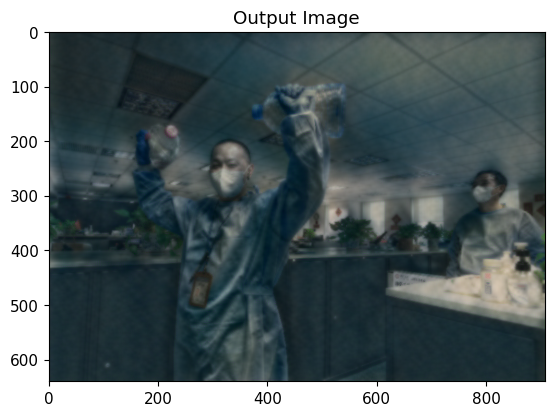

In [192]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)


plt.figure()
imshow(output, title='Output Image')

output_pil = transforms.ToPILImage()(output.cpu().clone().squeeze(0))

# Save the output image as JPEG
output_pil.save("data/images/output_image.jpg")

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

# Blend

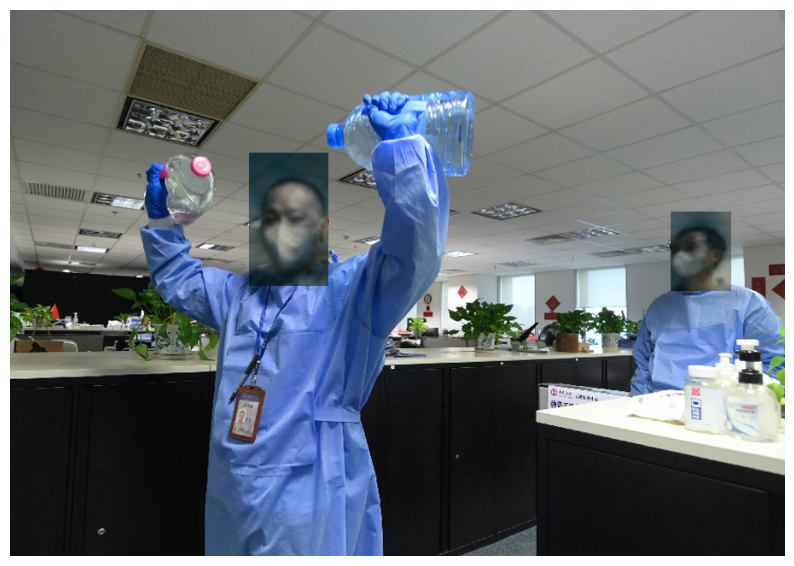

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
from PIL import Image, ImageDraw

# Assuming you have the correct paths for the images
styled_image_path = "data/images/output_image.jpg"
content_image_path = "data/images/detect.jpeg"

# Load the images
styled_image = Image.open(styled_image_path)
content_image = Image.open(content_image_path)

# Resize the content image to match the size of the styled image
content_image_resized = content_image.resize(styled_image.size)

# Create a blank mask with the same size as the styled image, start with a fully transparent mask (0)
mask = Image.new("L", styled_image.size, 0)

# Draw opaque rectangles (255) for each bounding box region
mask_draw = ImageDraw.Draw(mask)
scaled_bboxes = [ [280, 168, 372, 323], [774, 237, 844, 329]]

for bbox in scaled_bboxes:
    mask_draw.rectangle(bbox, fill=255)  # 255 means fully opaque in the mask

# Composite the styled image with the content image using the mask
result = Image.composite(styled_image, content_image_resized, mask)

# Save the result image
result.save("data/images/result_image.jpg")

# Display the result (original image with transparent bounding boxes)
plt.figure(figsize=(10, 10))
plt.imshow(result)
plt.axis("off")
plt.show()


# Appendix

Additional content below.

In [ ]:
# YOLOv5 PyTorch HUB Inference (DetectionModels only)
import torch

model = torch.hub.load('ultralytics/yolov5', 'yolov5s', force_reload=True, trust_repo=True)  # or yolov5n - yolov5x6 or custom
im = 'https://ultralytics.com/images/zidane.jpg'  # file, Path, PIL.Image, OpenCV, nparray, list
results = model(im)  # inference
results.print()  # or .show(), .save(), .crop(), .pandas(), etc.

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 v7.0-294-gdb125a20 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
image 1/1: 720x1280 2 persons, 2 ties
Speed: 708.1ms pre-process, 65.9ms inference, 3.2ms NMS per image at shape (1, 3, 384, 640)
